![header](./figures/logos_partenaires._cmems_se.jpg)

# Quickstart SWOT Swath Filtering

<div style="text-align: right"><i> 2022-09-19 QUICKSTART </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2022 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
    <h1><center>Quickstart</center></h1>
    <h5>Context: The row SWOT data will be contaminated by instrumental errors (Gauthier et al., 2016 ; Peral and Esteban-Fernandez, 2018). 
    In order to be able to observe front, mesoscale and sub-mesoscale features the SWOT data will require specific processing. 
    Also, these errors are expected to strongly pollute the derivatives of the SSH data which are used for the computation of geostrophic currents. Hence, being able to remove the SWOT errors are of significant importance to recover information on 2D surface currents and vertical mixing.</h5> 
</div> 


***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">
    
<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can display unfiltered, filtered SWOT Level3 SSH products.</li>
  <li>How you can evaluate the median filter: compare filtered with vs simulated target field</li>
</ul>
    
</div>



In [16]:
import os
import glob
import sys
from src.benchmark import *
from src.plot import *
from src.swot import *
import matplotlib.pylab as plt

<div class="alert alert-info" role="alert">

<h2>0. Download input files </h2>

</div>

In [17]:
# Check if inputs have already been downloaded otherwise do
if not os.path.isdir('dc_inputs'):
    # Get pseuso-observation
    !wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/2022a_SWOT_karin_error_filtering/dc_inputs.tar.gz
    !tar -xvf dc_inputs.tar.gz --directory .
    !rm -f dc_inputs.tar.gz

<div class="alert alert-info" role="alert">

<h2>1. Read input files
<h4> - "ssh_karin" the input variable
<h4> - "ssh_true" the target variable
<h4> Only the third SWOT pass is filtered as an illustration</div>


In [18]:
list_of_inputs = sorted(glob.glob('dc_inputs/input_ssh_karin_013_00*.nc'))

# Only the third SWOT pass for quickstart example
swt_input = SwotTrack(list_of_inputs[3])
swt_input._dset

<xarray.Dataset>
Dimensions:                  (num_lines: 3887, num_pixels: 71)
Coordinates:
    latitude                 (num_lines, num_pixels) float64 ...
    longitude                (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    ssh_true                 (num_lines, num_pixels) float64 ...
    ssh_karin                (num_lines, num_pixels) float64 ...
    time                     (num_lines) datetime64[ns] ...
    mask_coastline_200km     (num_lines, num_pixels) float64 ...
    mask_ssh_var_over200cm2  (num_lines, num_pixels) float64 ...
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-11-27 11:46:50Z : Creation
    platform:                   SWOT
    ...                         ...
    right_last_longitude:       332.62709605367274
    right_last_latitude:        67.03346174073806
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.0033528106647474805

<div class="alert alert-info" role="alert">

<h2>2. Compute geostrophic velocities from simulated true SSH karin and from simulated noisy SSH karin </h2>

</div>

The geostrophic currents calculation is:
$$
u_g(x,y) = - \frac{g}{f(x,y)}\frac{\partial h(x,y)}{\partial y}
$$
$$
v_g(x,y) = \frac{g}{f(x,y)}\frac{\partial h(x,y)}{\partial x}
$$
$$
\vec{U_g} = u_g.\vec{x} + v_g.\vec{y} 
$$

with:

$ f(x,y) = 2 \Omega sin(latitude(x,y))$ ,the Coriolis frequency

$\vec{x}$ and $\vec{y}$ define the local frame of reference in the swath

*Note: For simplification, we considered here:* 
- a 3-points stencil width, the first derivatives discretisation schemes, such as:

$$
\frac{\partial h(x,y)}{\partial y} = \frac{ h(i, j+1) - h(i, j-1) } {2 dy}, 
$$

- the beta plane approximation for the derivation of the geostrophic current near the Equator is not implemented 

In [19]:
swt_input.compute_geos_current('ssh_karin', 'geos_current_karin')
swt_input.compute_geos_current('ssh_true', 'geos_current_true')

<div class="alert alert-info" role="alert">

<h2>3. Compute relative vorticity from simulated true geostrophic velocities and from simulated noisy geostrophic velocities </h2>

</div>

The relative vorticity (normalized by $f$) is derived from the geostrophic current field:

$$
\zeta_f = \frac{1}{f} (\frac{\partial v_g}{\partial x} - \frac{\partial u_g}{\partial y})
$$

a 3-points stencil width is also considered for these derivative

In [20]:
swt_input.compute_relative_vorticity('geos_current_true_x', 'geos_current_true_y', 'ksi_true')
swt_input.compute_relative_vorticity('geos_current_karin_x', 'geos_current_karin_y', 'ksi_karin')

<div class="alert alert-info" role="alert">

<h2>4. Example of INPUT field: Simulated SWOT noisy Sea surface Height data and derived geostrophic current </h2>
<h5> The input SSH field is here polluted by random noise (Left Figure) as precribed by the SWOTsimulator. This noise pollution has a strong impact on the first derivative of the SSH field: the geostrophic currents </h5>
    
</div>

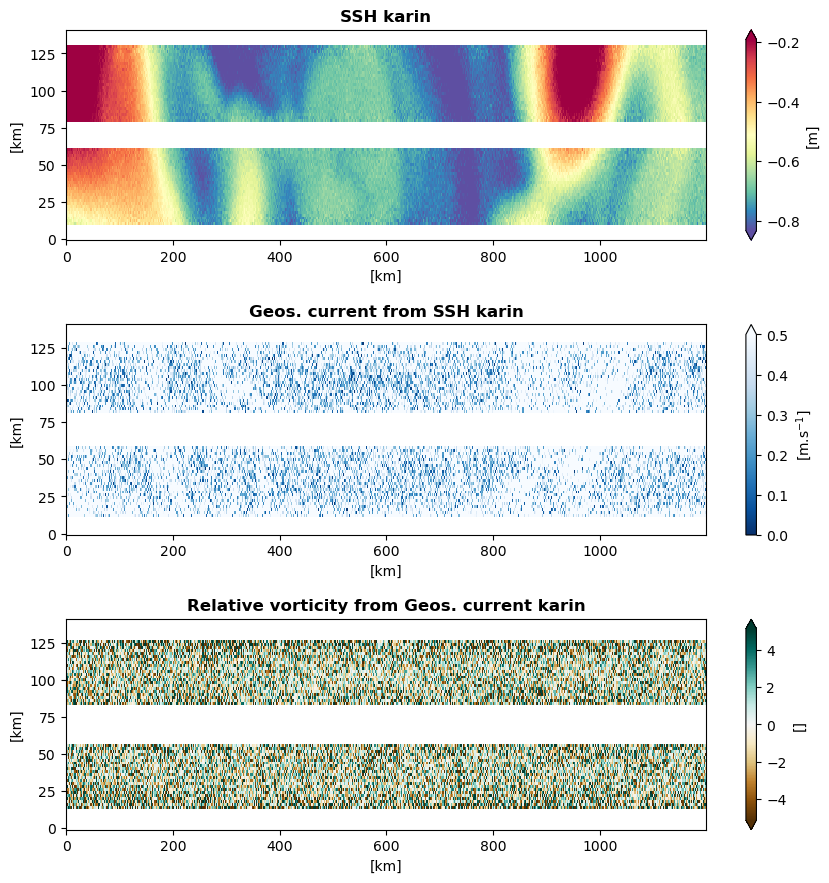

In [21]:
mask, vmin, vmax = swt_input.display_demo('karin')

<div class="alert alert-info" role="alert">

<h2>5. Example of TARGET field to reconstruct: Simulated True SWOT Sea surface Height data and derived geostrophic current </h2>

</div>

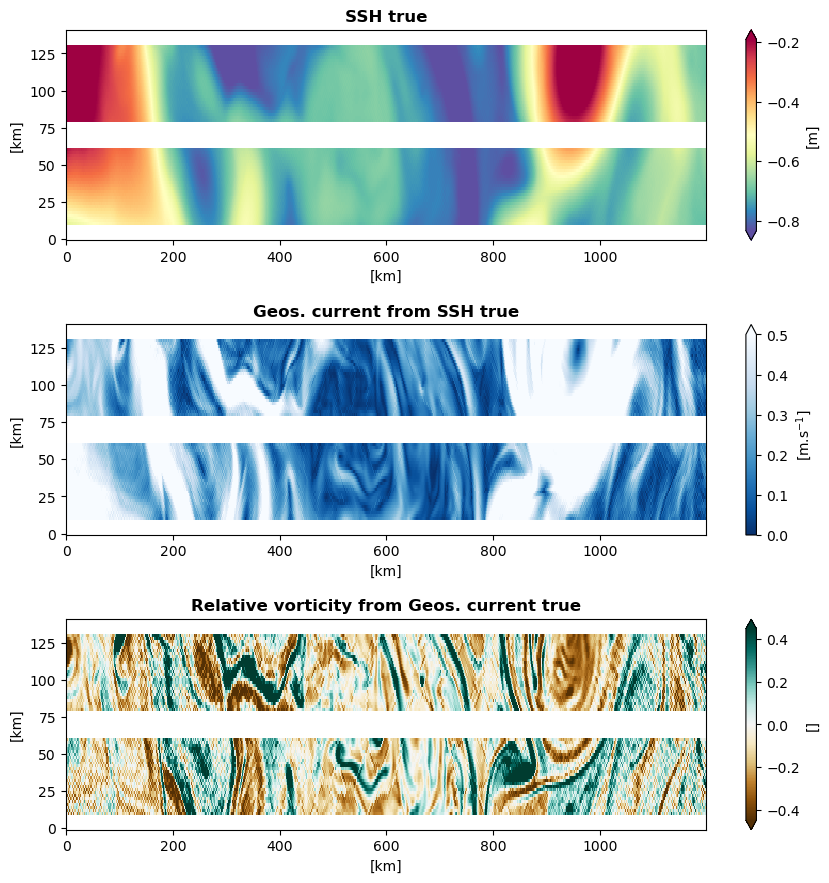

In [22]:
tmp_msk, tmp_v0, tmp_v1 = swt_input.display_demo('true', mask, vmin, vmax)

<div class="alert alert-info" role="alert">

<h2>6. Apply MEDIAN filter by using "apply_your_own_filter" function </h2>

</div>

In [23]:
# Creating a function that filters an SSH field using a median filter

def my_filter0(ssha,size):
    from src.filters_bidim import median_filter 
    
    return median_filter(ssha, size)

In [24]:
# Applying your function by passing it as argument of "apply_your_own_filter"
#
# (the arguments of my_filter0 are passed at the end of apply_your_own_filter call, here, size=10 )

swt_input.apply_your_own_filter(thefilter=my_filter0, invar='ssh_karin', outvar='ssh_karin_filt', size=10)


<div class="alert alert-info" role="alert">

<h2>7. Compute geostrophic current from this filtered SSH </h2>

</div>

In [25]:
swt_input.compute_geos_current('ssh_karin_filt', 'geos_current_karin_filt')
swt_input.compute_relative_vorticity('geos_current_karin_filt_x', 'geos_current_karin_filt_y', 'ksi_karin_filt')

<div class="alert alert-info" role="alert">

<h2>8. Display performance of  MEDIAN filter </h2>

</div>

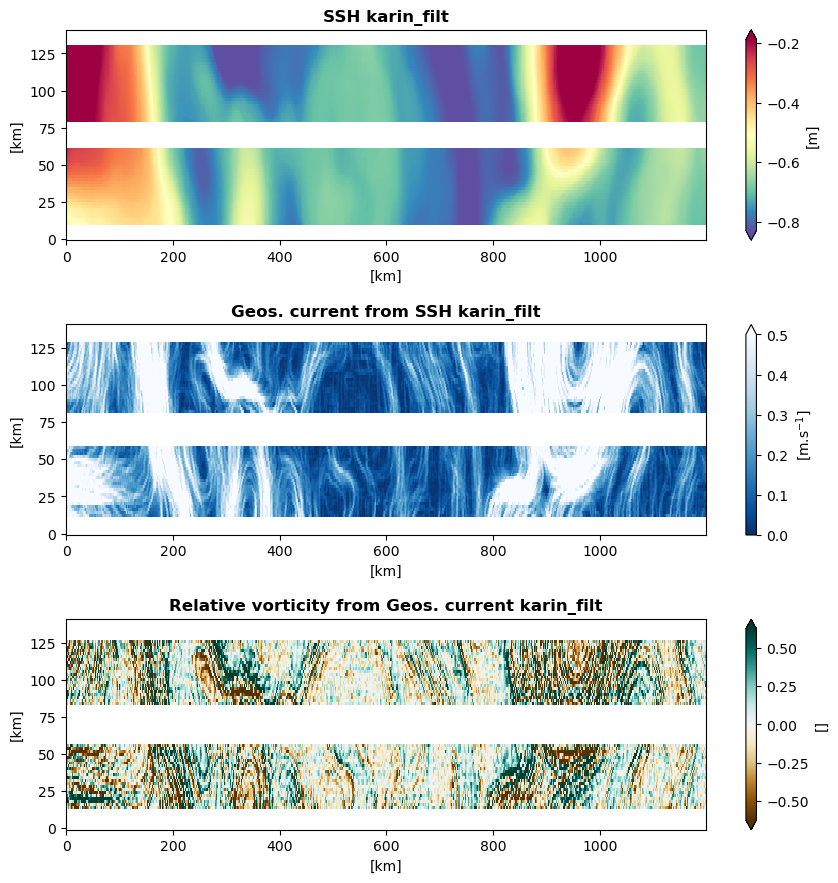

In [26]:
tmp_msk, tmp_v0, tmp_v1 = swt_input.display_demo('karin_filt')

<div class="alert alert-info" role="alert">

<h2>9. Save filtered output </h2>

</div>

In [28]:
output_var_names = ['ssh_karin_filt', 'longitude',  'latitude']
output_file_path = './results/quickstart_my_filter0.nc' 
swt_input.to_netcdf(output_var_names, output_file_path)